In [1273]:
# Reload and changes to module without having to restart kernel.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- imbalance, absolute standardised difference (before matching, after PSM, after MDM) *done*
- histograms of variables (before matching, after PSM, after MDM) *done*
- histograms of causal variable and outcome variable (before matching, after PSM, after MDM)
- ATE, average outcome for g0 and g1, ttest and nonparametric (before matching, after PSM, after MDM) *done*
- number of matched g0s (after PSM, after MDM)

In [1274]:
# PRUNING_MDM = 1e9
# PRUNING_PSM = 1e9

# PRUNING_MDM = 0.5
# PRUNING_PSM = 0.0005

PRUNING_MDM = 1
PRUNING_PSM = 0.005

# Imports

In [1275]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [1276]:
import loneliness.psm as psm
import loneliness.mdm as mdm
import loneliness.measures as measures
import loneliness.plots as plots

# Load features matrix

In [1277]:
features = pd.read_csv("features.csv", index_col='pcstrip')

# features['target'] = features['target2'].values

feature_vars_all = ['ru_rank', 'moves_in_zscore',
                'gp_norm_gp0_9', 'gp_norm_gp10_24', 'gp_norm_gp25_49',
                'gp_norm_gp50_79', 'gp_norm_gp80p', 'index_multiple_deprivation',
                'nearby_schools_zscore']

features = features[feature_vars_all+['target']]

In [1335]:
features = features[(features['target'] > -8) & (features['target'] < 8)]

In [1336]:
tests = ['nearby_schools_zscore', 'gp_norm_gp80p', 'gp_norm_gp10_24', 'moves_in_zscore', 'ru_rank', 'index_multiple_deprivation']

In [1337]:
treatment_name = 'nearby_schools_zscore'

feature_vars = np.setdiff1d(feature_vars_all, [treatment_name])

quantile_25 = features[treatment_name].quantile(0.50)
quantile_75 = features[treatment_name].quantile(0.50)

def f(x, quantile_25, quantile_75):
    if x <= quantile_25: return 0
    if x > quantile_75: return 1
    else: return -1

treatment = psm.create_treatment_variable(features[treatment_name], criteria=lambda z: f(z, quantile_25, quantile_75))

features[treatment.name] = treatment

Created boolean feature 'nearby_schools_zscore_bool_custom'. 
Feature distribution:
 0    3182
1    3159
Name: nearby_schools_zscore_bool_custom, dtype: int64


In [1338]:
features = features[features[treatment.name] != -1]
treatment = treatment[treatment != -1]

### Measure average treatment effect before matching

In [1339]:
ate_before, ttest_before, mwu_before = measures.average_treatment_effect(target=features.target, splitter=treatment)

ATE = -0.6662662646466353


### Measure imbalance before matching

In [1340]:
asd_before = measures.absolute_standardised_difference(features, feature_vars, treatment_var = treatment)

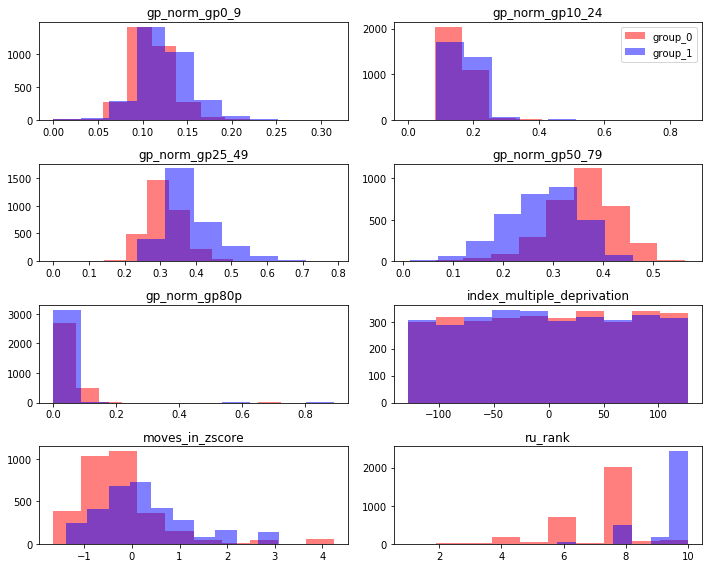

In [1341]:
plots.var_histograms(features, feature_vars, treatment)
plt.savefig("./fig/pre_match_hist.png")

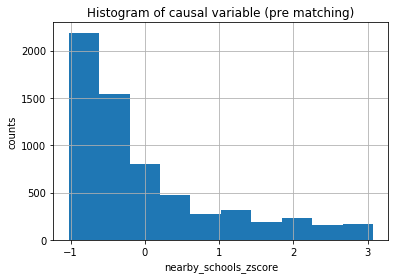

In [1342]:
features[treatment_name].hist()

plt.title("Histogram of causal variable (pre matching)")
plt.xlabel(treatment_name)
plt.ylabel('counts')

plt.savefig("hist_causal.png")

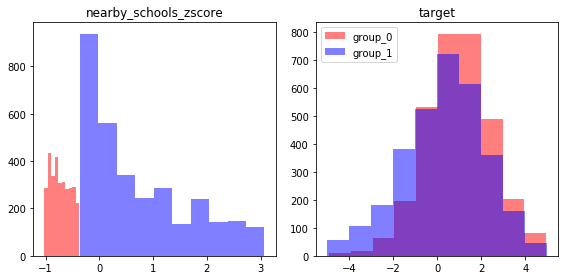

In [1343]:
plots.var_histograms_causal_target(features, feature_vars, treatment, treatment_name)

In [1344]:
g0_size = sum(features[treatment.name] == 0)
print("size g0 = {}".format(g0_size))

g1_size = sum(features[treatment.name] == 1)
print("size g1 = {}".format(g1_size))

size g0 = 3182
size g1 = 3159


# Propensity Score Matching

In [1345]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

clf_nn = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,50,50,), learning_rate='adaptive', max_iter=500)
clf_lr = LogisticRegression(solver='liblinear', penalty='l2')

In [1346]:
features['prop_score'] = psm.get_propensity_scores(treatment, features[feature_vars], return_labels = False, classifier=clf_lr)

prop score accuracy:  0.8873994638069705


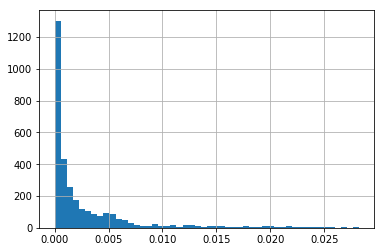

In [1347]:
matches, group_0_psm, group_1_psm = psm.propensity_match(features, treatment, prune = PRUNING_PSM)

### Average treatment effect after Propensity Score Matching

ATE: 0.22881799436109637


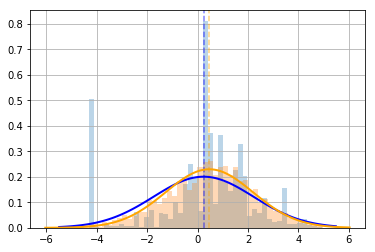

In [1348]:
ate_psm, ttest_psm, mwu_psm = measures.average_treatment_effect(g0=group_0_psm, g1=group_1_psm)

### Imbalance (absolute standardised difference) after Propensity Score Matching

In [1349]:
asd_psm = measures.absolute_standardised_difference(features, feature_vars, g0=group_0_psm, g1=group_1_psm)

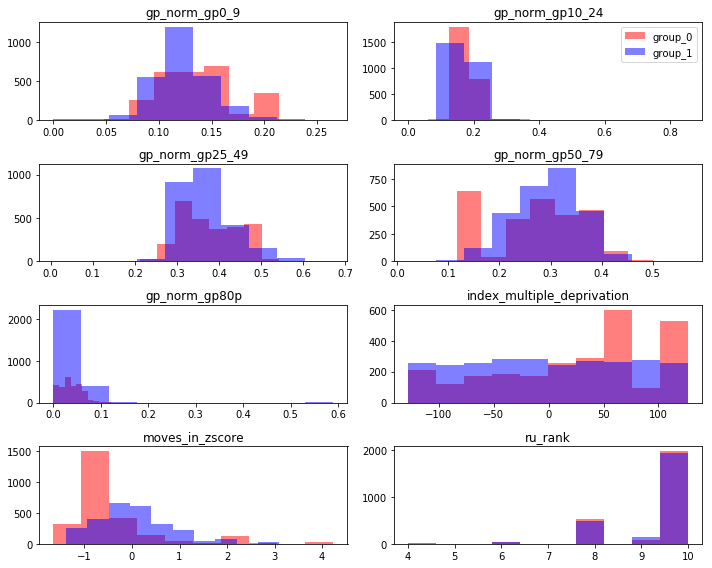

In [1350]:
plots.var_histograms_matched(group_0_psm, group_1_psm, feature_vars)

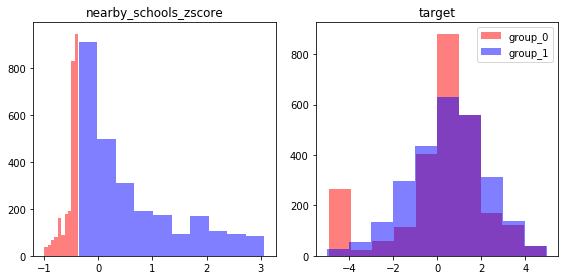

In [1351]:
plots.var_histograms_matched_causal_target(group_0_psm, group_1_psm, treatment, treatment_name)

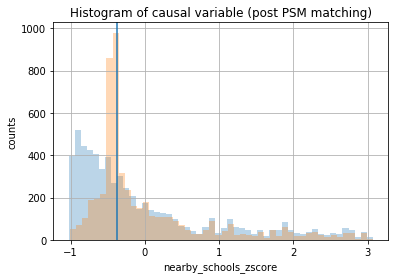

In [1352]:
features[treatment_name].hist(alpha=0.3, bins=50)
pd.concat([group_0_psm[treatment_name], group_1_psm[treatment_name]]).hist(alpha=0.3, bins=50)
plt.axvline(features[treatment_name].median())

plt.title("Histogram of causal variable (post PSM matching)")
plt.xlabel(treatment_name)
plt.ylabel('counts')

plt.savefig("./fig/hist_causal_{}.png".format(treatment_name))

In [1353]:
matches_g0_psm = len(np.unique(group_0_psm.index.values))
print("# GP's in G0 matched to a GP in G1 = {}, ({:.1f}%)".format( matches_g0_psm,100*matches_g0_psm/len(group_0_psm.index.values)  ))

matches_g1_psm = len(np.unique(group_1_psm.index.values))
print("# GP's in G1 matched to a GP in G0 = {}, ({:.1f}%)".format( matches_g1_psm,100*matches_g1_psm/len(group_1_psm.index.values)  ))

# GP's in G0 matched to a GP in G1 = 589, (22.4%)
# GP's in G1 matched to a GP in G0 = 2630, (100.0%)


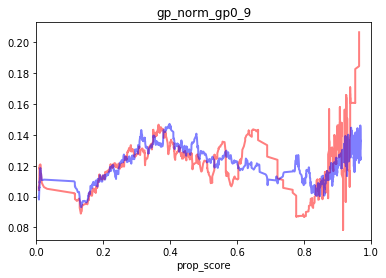

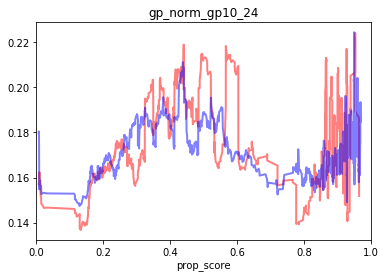

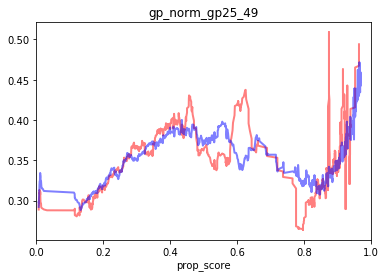

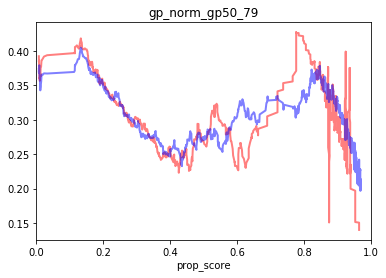

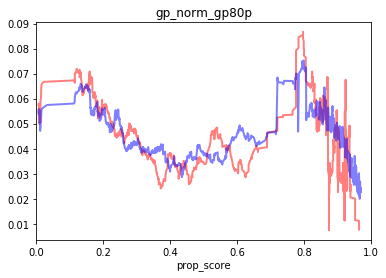

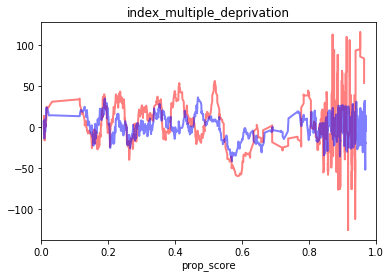

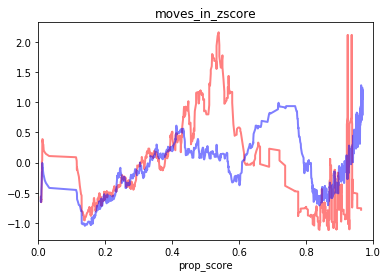

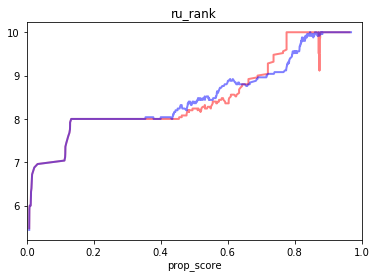

In [1354]:
plots.var_vs_prop(features, feature_vars, treatment, group_0_psm, group_1_psm)

# Propensity Score Matching (ATE)

In [1355]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

clf_nn = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,50,50,), learning_rate='adaptive', max_iter=500)
clf_lr = LogisticRegression(solver='liblinear', penalty='l2')

In [1356]:
features['prop_score'] = psm.get_propensity_scores(treatment, features[feature_vars], return_labels = False, classifier=clf_lr)

prop score accuracy:  0.8873994638069705


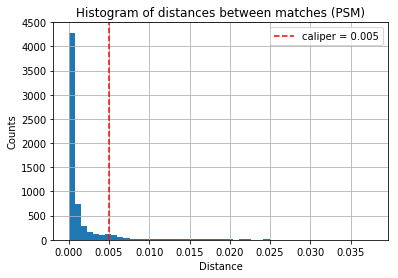

In [1357]:
matches, group_0_psm_ate, group_1_psm_ate = psm.propensity_match_g0g1(features, treatment, prune=PRUNING_PSM)

plt.axvline(PRUNING_PSM, ls = "--", c='r', label='caliper = {}'.format(PRUNING_PSM))

plt.xlabel("Distance")
plt.ylabel("Counts")
plt.title("Histogram of distances between matches (PSM)")
plt.legend()

plt.savefig("./fig/distance_caliper_psm.png")

### Average treatment effect after Propensity Score Matching

ATE: 0.015443422992953478


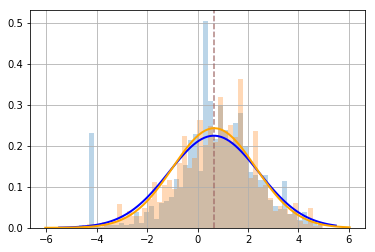

In [1358]:
ate_psm_ate, ttest_psm_ate, mwu_psm_ate = measures.average_treatment_effect(g0=group_0_psm_ate, g1=group_1_psm_ate)

### Imbalance (absolute standardised difference) after Propensity Score Matching

In [1359]:
asd_psm_ate = measures.absolute_standardised_difference(features, feature_vars, g0=group_0_psm_ate, g1=group_1_psm_ate)

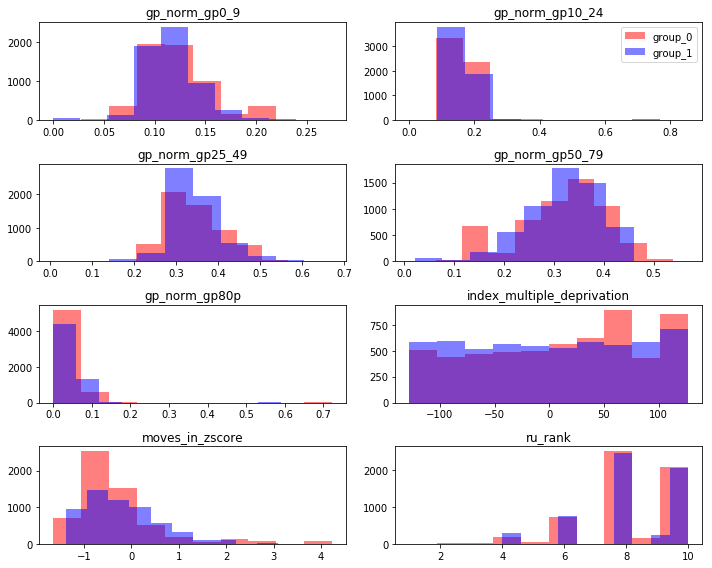

In [1360]:
plots.var_histograms_matched(group_0_psm_ate, group_1_psm_ate, feature_vars)
plt.savefig("./fig/pre_match_hist_psm.png")

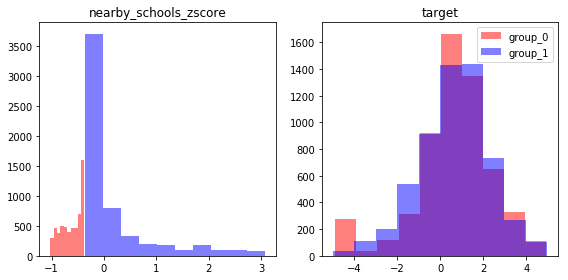

In [1361]:
plots.var_histograms_matched_causal_target(group_0_psm_ate, group_1_psm_ate, treatment, treatment_name)

In [1362]:
matches_g0_psm_ate = len(np.unique(group_0_psm_ate.index.values))
print("# GP's in G0 matched to a GP in G1 = {}, ({:.1f}%)".format( matches_g0_psm_ate,100*matches_g0_psm_ate/len(group_0_psm_ate.index.values)  ))

matches_g1_psm_ate = len(np.unique(group_1_psm_ate.index.values))
print("# GP's in G1 matched to a GP in G0 = {}, ({:.1f}%)".format( matches_g1_psm_ate,100*matches_g1_psm_ate/len(group_1_psm_ate.index.values)  ))

# GP's in G0 matched to a GP in G1 = 3147, (54.5%)
# GP's in G1 matched to a GP in G0 = 2630, (45.5%)


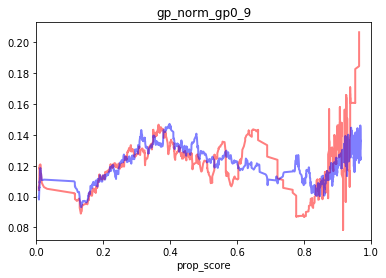

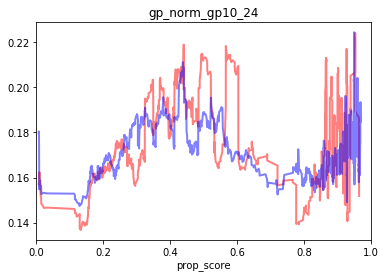

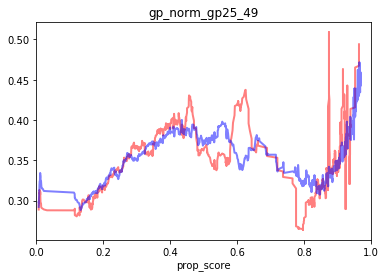

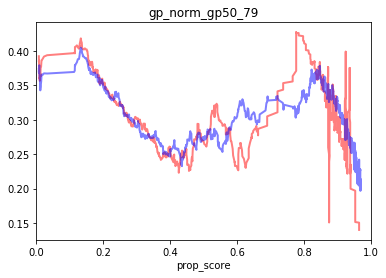

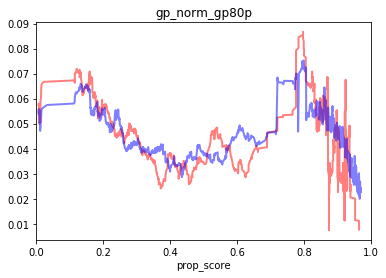

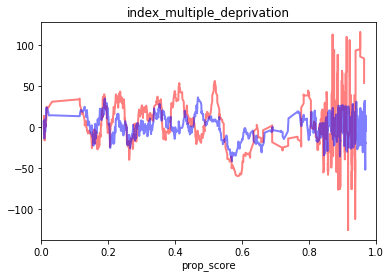

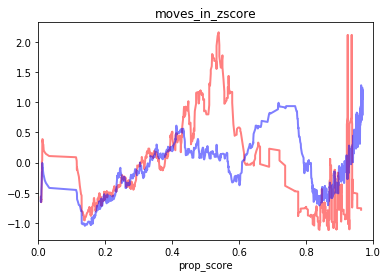

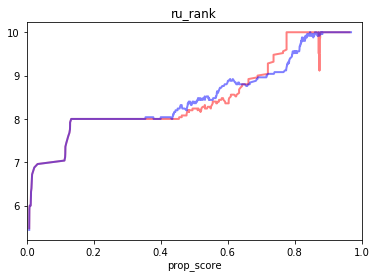

In [1363]:
plots.var_vs_prop(features, feature_vars, treatment, group_0_psm, group_1_psm)

# Mahalanobis Distance Matching (ATE)

In [1364]:
control_group = features[features[treatment.name] == 0]
treatment_group = features[features[treatment.name] == 1]

In [1365]:
import os

if os.path.isfile('./mdm_{}.csv'.format(treatment_name)):
    
    matches_mdm = pd.read_csv('./mdm_{}.csv'.format(treatment_name), index_col=0)
    matches_mdm_g1 = pd.read_csv('./mdm_att_{}.csv'.format(treatment_name), index_col=0)
else:
    matches_mdm_g1, group_0_mdm, group_1_mdm = mdm.nearest_neighbours_match(control_group, treatment_group, features, feature_vars)
    matches_mdm_g0, group_0_mdm, group_1_mdm = mdm.nearest_neighbours_match(treatment_group, control_group, features, feature_vars)
    
    matches_mdm_g0.columns = ['g0', 'dist', 'g1']
    matches_mdm_g0 = matches_mdm_g0[['g1', 'dist', 'g0']]

    matches_mdm = pd.concat([matches_mdm_g0, matches_mdm_g1])
    
    matches_mdm_g1.to_csv("./mdm_att_{}.csv".format(treatment_name))

    matches_mdm.to_csv('./mdm_{}.csv'.format(treatment_name))

In [1366]:
matches_mdm_ate = matches_mdm
matches_mdm_ate.dist = matches_mdm_ate.dist.astype(float)

In [1367]:
matches_mdm_ate.dist.median()

0.7792529423447463

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


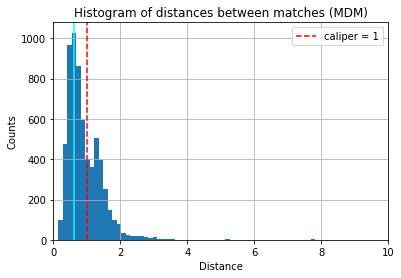

In [1368]:
matches_mdm_ate.dist.hist(bins=100)
plt.xlim(0, 10)

matches_mdm_ate = matches_mdm_ate[ matches_mdm_ate.dist < PRUNING_MDM ]

plt.axvline(PRUNING_MDM, ls = "--", c='r', label='caliper = {}'.format(PRUNING_MDM))
plt.axvline(matches_mdm_ate.dist.median(), c = 'cyan')
plt.xlabel("Distance")
plt.ylabel("Counts")
plt.title("Histogram of distances between matches (MDM)")
plt.legend()

group_0_mdm_ate = features.loc[matches_mdm_ate['g0']]
group_1_mdm_ate = features.loc[matches_mdm_ate['g1']]

plt.savefig("./fig/distance_caliper_mdm.png")

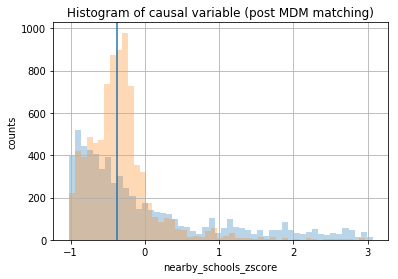

In [1389]:
features[treatment_name].hist(alpha=0.3, bins=50)
pd.concat([group_0_mdm_ate[treatment_name], group_1_mdm_ate[treatment_name]]).hist(alpha=0.3, bins=50)
plt.axvline(features[treatment_name].median())

plt.title("Histogram of causal variable (post MDM matching)")
plt.xlabel(treatment_name)
plt.ylabel('counts')

plt.savefig("./fig/hist_causal_{}.png".format(treatment_name))

### Average treatment effect after Mahalanobis Distance Matching

/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


ATE: -0.21572067913761403


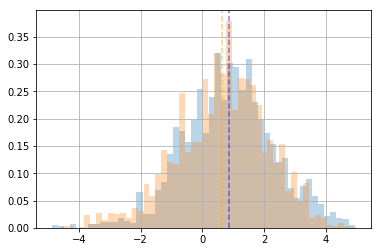

In [1369]:
ate_mdm_ate, ttest_mdm_ate, mwu_mdm_ate = measures.average_treatment_effect(g0=group_0_mdm_ate, g1=group_1_mdm_ate)

### Imbalance (absolute standardised difference) after Mahalanobis Distance Matching

In [1370]:
asd_mdm_ate = measures.absolute_standardised_difference(features, feature_vars, g0=group_0_mdm_ate, g1=group_1_mdm_ate)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


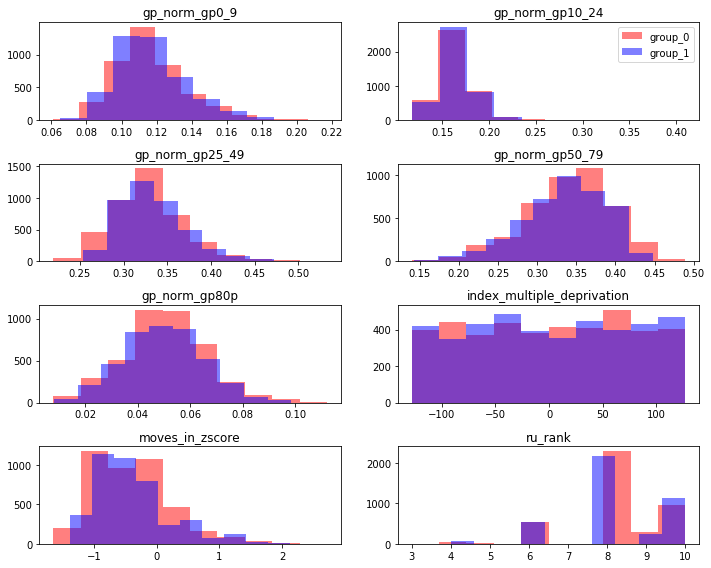

In [1371]:
plots.var_histograms_matched(group_0_mdm_ate, group_1_mdm_ate, feature_vars)
plt.savefig("./fig/pre_match_hist_mdm.png")

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


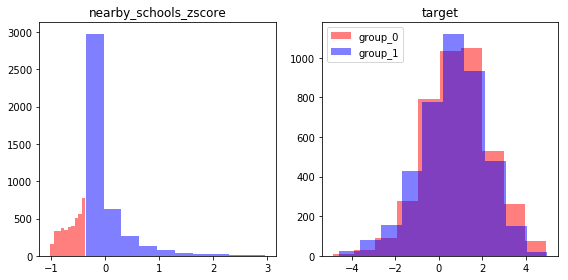

In [1372]:
plots.var_histograms_matched_causal_target(group_0_mdm_ate, group_1_mdm_ate, treatment, treatment_name)

In [1373]:
matches_g0_mdm_ate = len(np.unique(group_0_mdm_ate.index.values))
print("# GP's in G0 matched to a GP in G1 = {}, ({:.1f}%)".format( matches_g0_mdm_ate, 100*matches_g0_mdm_ate/len(group_0_mdm_ate.index.values)  ))

matches_g1_mdm_ate = len(np.unique(group_1_mdm_ate.index.values))
print("# GP's in G1 matched to a GP in G0 = {}, ({:.1f}%)".format( matches_g1_mdm_ate, 100*matches_g1_mdm_ate/len(group_1_mdm_ate.index.values)  ))

# GP's in G0 matched to a GP in G1 = 2526, (60.5%)
# GP's in G1 matched to a GP in G0 = 1652, (39.5%)


# Mahalanobis Distance Matching

In [1374]:
control_group = features[features[treatment.name] == 0]
treatment_group = features[features[treatment.name] == 1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


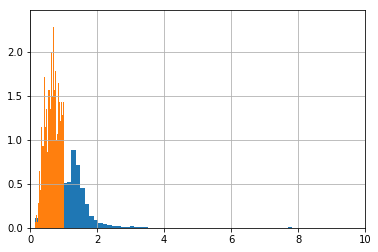

In [1375]:
matches_mdm = matches_mdm_g1
matches_mdm.dist = matches_mdm.dist.astype(float)

matches_mdm.dist.hist(bins=100, density=True)
matches_mdm = matches_mdm[ matches_mdm.dist < PRUNING_MDM ]
matches_mdm.dist.hist(bins=100, density=True)
plt.xlim(0, 10)

group_0_mdm = features.loc[matches_mdm['g0']]
group_1_mdm = features.loc[matches_mdm['g1']]

### Average treatment effect after Mahalanobis Distance Matching

/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


ATE: -0.1071964867423985


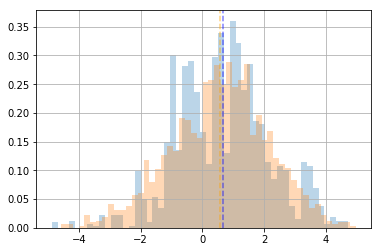

In [1376]:
ate_mdm, ttest_mdm, mwu_mdm = measures.average_treatment_effect(g0=group_0_mdm, g1=group_1_mdm)

# plt.axvline(control_group.target.mean(), c='b')
# plt.axvline(treatment_group.target.mean(), c='orange')

### Imbalance (absolute standardised difference) after Mahalanobis Distance Matching

In [1377]:
asd_mdm = measures.absolute_standardised_difference(features, feature_vars, g0=group_0_mdm, g1=group_1_mdm)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


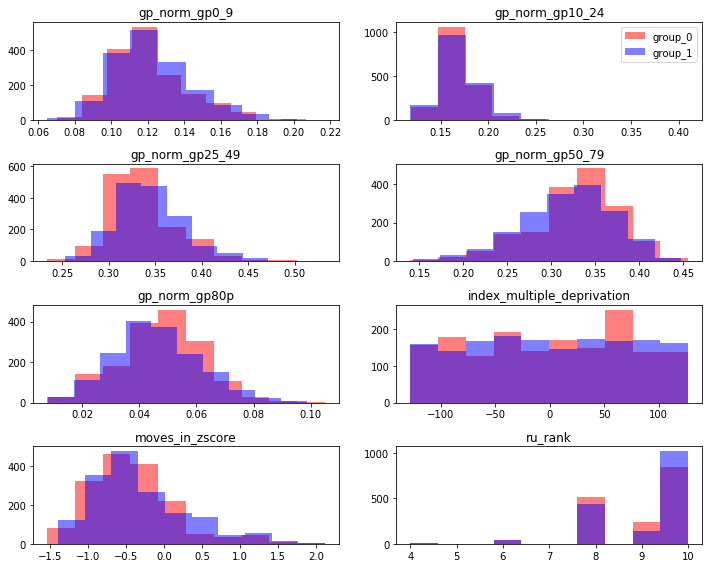

In [1378]:
plots.var_histograms_matched(group_0_mdm, group_1_mdm, feature_vars)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


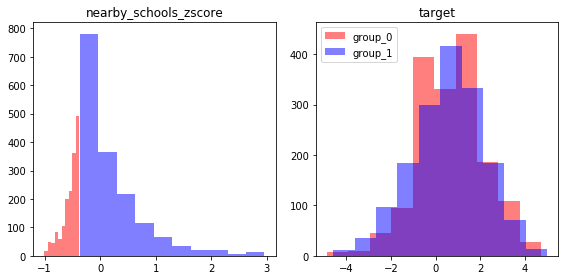

In [1379]:
plots.var_histograms_matched_causal_target(group_0_mdm, group_1_mdm, treatment, treatment_name)

In [1380]:
matches_g0_mdm = len(np.unique(group_0_mdm.index.values))
print("# GP's in G0 matched to a GP in G1 = {}, ({:.1f}%)".format( matches_g0_mdm, 100*matches_g0_mdm/len(group_0_mdm.index.values)  ))

matches_g1_mdm = len(np.unique(group_1_mdm.index.values))
print("# GP's in G1 matched to a GP in G0 = {}, ({:.1f}%)".format( matches_g1_mdm, 100*matches_g1_mdm/len(group_1_mdm.index.values)  ))

# GP's in G0 matched to a GP in G1 = 607, (36.7%)
# GP's in G1 matched to a GP in G0 = 1652, (100.0%)


# Summary

In [1381]:
def sig(x):
    if x[1] < 0.05: 
        return "{}*".format(np.round(x[1], 4))
    else:
        return "{}".format(np.round(x[1], 4))

In [1382]:
# stats = pd.DataFrame({"before" : [ate_before, sig(ttest_before), sig(mwu_before), asd_before, g0_size, g1_size],
#                       "mdm-att" : [ate_mdm, sig(ttest_mdm), sig(mwu_mdm), asd_mdm, matches_g0_mdm, matches_g1_mdm],
#                       "mdm-ate" : [ate_mdm_ate, sig(ttest_mdm_ate), sig(mwu_mdm_ate), asd_mdm_ate, matches_g0_mdm_ate, matches_g1_mdm_ate],
#                       "psm-att" : [ate_psm, sig(ttest_psm), sig(mwu_psm), asd_psm, matches_g0_psm, matches_g1_psm],
#                       "psm-ate" : [ate_psm_ate, sig(ttest_psm_ate), sig(mwu_psm_ate), asd_psm_ate, matches_g0_psm_ate, matches_g1_psm_ate]}).T

In [1383]:
# stats.columns = ['Mean difference', 't-test', 'u-test', 'imbalance', '\|G0\|', '\|G1\|']

In [1384]:
stats = pd.DataFrame({"before" : [ate_before, sig(ttest_before), asd_before],
                      "mdm-ate" : [ate_mdm_ate, sig(ttest_mdm_ate), asd_mdm_ate],
                      "psm-ate" : [ate_psm_ate, sig(ttest_psm_ate), asd_psm_ate]}).T

In [1385]:
stats.columns = ['Mean difference', 't-test', 'imbalance']

In [1386]:
stats

,Mean difference,t-test,imbalance
before,-0.666266,0.0*,0.654098
mdm-ate,-0.215721,nan,0.0421339
psm-ate,0.0154434,0.6276,0.0804649


In [1387]:
stats.to_csv('./results/{}.csv'.format(treatment_name))

In [1331]:
from tabulate import tabulate

In [1332]:
with open("./results/{}.md".format(treatment_name), 'w') as file: # Use file to refer to the file object

    file.write("\n### " + treatment_name + "\n\n" + tabulate(stats, tablefmt='github',headers='keys')+"\n")


In [1333]:
sig(mwu_mdm_ate)

'0.0*'

In [1334]:
sig(mwu_psm_ate)

'0.1469'